# Acknowledgments

Dataset was found on UCI : https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

# Helper Functions

create_dataset() takes in [dataset_size, 4] matrix, where the 1st column represents Global Active Power, and columns 2-4 represent the meter values of Zone 1 (kitchen), Zone 2 (laundry room), and Zone 3 (water-heater, air conditioner) respetively

In [ ]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    
    # Loop through dataset, not including the first "look_back" values
    for i in range(len(dataset)-look_back-1):

        # a grabs the previous look back features for [global active power, 
        # Sub metering 1, sub metering 2, sub metering 3]
        a = dataset[i:(i+look_back), 0:4]

        # a becomes the features and gets appended to X
        X.append(a)

        # The current [global active power, sub metering 1, sub metering 2,
        # Sub metering 3] becomes the label
        Y.append(dataset[i + look_back, 0:4])

    # Return the features and labels
    return np.array(X), np.array(Y)

# Imports


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Import mean squared error and mean absolute error from sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Import necessary functions from keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import *


# Import early stopping from keras callbacks
from keras.callbacks import EarlyStopping

!pip install visualkeras
import visualkeras

# Import seaborn library and set context and style
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 15.9 MB/s eta 0:00:00


# Grab Dataset

NOTE: MOUNT GOOGLE DRIVE TO NOTEBOOK, BEFORE PROCEEDING

This dataset is the Household Electric Power Consumption, which is a time series dataset that measures the energy output of a single house over 47 months (December,2006 - November, 2010). The data is sampled per minute, containing 2075259 data points.


In [ ]:
# Input the household power consumption dataset
#df = pd.read_csv('/content/drive/MyDrive/Dataset/household_power_consumption.txt', delimiter=';') - example
df = pd.read_csv(INSERT DATA FILE PATH HERE, delimiter=';')


print(f'Shape of df: {df.shape}')
print('First 5 rows of df \n')
df.head(5)

Shape of df: (2075259, 9)
First 5 rows of df 



<ipython-input-21-bfb5dfd5ebcd>:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Dataset/household_power_consumption.txt', delimiter=';')


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


# Feature Engineering

Create a date time object, utilizing pandas datatype. Drop all rows that have empty or NaN values.

In [ ]:
# Create date time object
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

In [ ]:
# Making all the types in the columns into floats
df.iloc[:,2:-1] = df.iloc[:,2:-1].apply(pd.to_numeric, errors = 'coerce')

print(f'Before dropping NA: {df.shape}')

# Droping the rows with NaN values
df.dropna(how='any', inplace=True)

print(f'After dropping NA: {df.shape}')

<ipython-input-23-e498de21056c>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,2:-1] = df.iloc[:,2:-1].apply(pd.to_numeric, errors = 'coerce')


Before dropping NA: (2075259, 10)
               Date      Time  Global_active_power  Global_reactive_power  \
0        16/12/2006  17:24:00                4.216                  0.418   
1        16/12/2006  17:25:00                5.360                  0.436   
2        16/12/2006  17:26:00                5.374                  0.498   
3        16/12/2006  17:27:00                5.388                  0.502   
4        16/12/2006  17:28:00                3.666                  0.528   
...             ...       ...                  ...                    ...   
2075254  26/11/2010  20:58:00                0.946                  0.000   
2075255  26/11/2010  20:59:00                0.944                  0.000   
2075256  26/11/2010  21:00:00                0.938                  0.000   
2075257  26/11/2010  21:01:00                0.934                  0.000   
2075258  26/11/2010  21:02:00                0.932                  0.000   

         Voltage  Global_intensity  Sub_m

Add year, quarter, month, and day columns to dataset. This will be utilized for data visualization.

Keep Global Active Power, Sub Metering 1, Sub Metering 2, and Sub Metering 3 as our labels/features

In [ ]:

# Construct year and month columns for possible data visualization
# Graphs.
df['year'] = pd.DatetimeIndex(df['date_time']).year
df['month'] = pd.DatetimeIndex(df['date_time']).month

# Only include the following columns for the dataset
df = df.loc[:,['date_time','Global_active_power', 'year','month','Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]

In [ ]:
print(f'Updated df: {df.shape}')
df.head(5)

Updated df: (2049280, 7)


,date_time,Global_active_power,year,month,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,2006,12,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,2006,12,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,2006,12,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,2006,12,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,2006,12,0.0,1.0,17.0


#Data Visualization

<Axes: xlabel='month', ylabel='Global_active_power'>

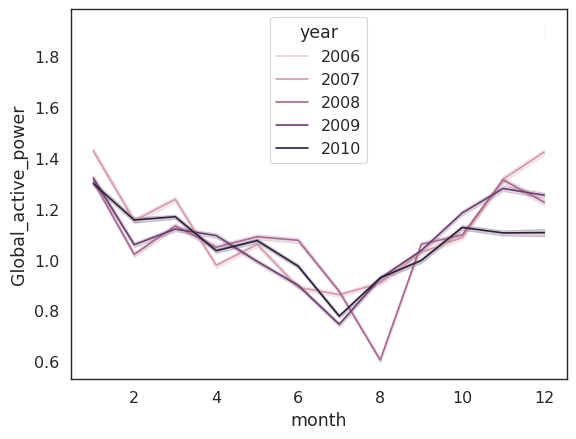

In [ ]:
#Create a lineplot of Global Active Power by month, with each year separated
sns.lineplot(x='month',y='Global_active_power',hue='year',data=df)


<Axes: xlabel='month', ylabel='Sub_metering_3'>

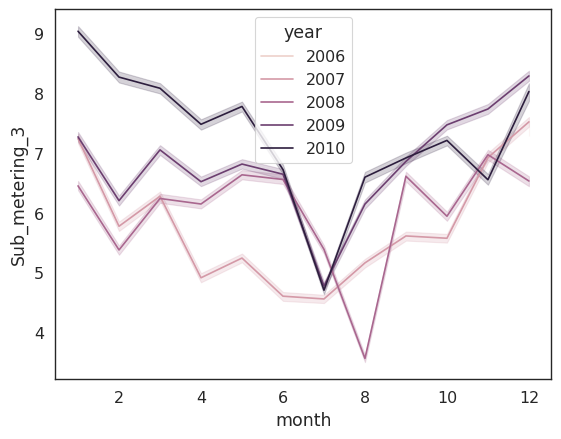

In [ ]:
#Create a similar lineplot but for sub_metering_3
sns.lineplot(x='month',y='Sub_metering_3',hue='year',data=df)

#Extract Global Active Power, Sub Metering 1, Sub Metering 2, Sub Metering 3

Scale data into range of 0 to 1 to remove bias from data with large variance

Create a train, validation, and test data set



In [ ]:
# Transform the Global_active_power column of the data DataFrame into a numpy array of float values
dataset = df[['Global_active_power','Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]

# Scale the values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the MinMaxScaler to the transformed data and transform the values
dataset = scaler.fit_transform(dataset)

# Split the transformed data into a training set (80%) and a test set (20%)
train_size = int(len(dataset) * 0.80)
val_size = int(train_size*.70) #Splits train into 70-30, 70->actual train, 30->validation
test_size = len(dataset) - train_size

# Based on the constructed sizes, separate the train, validation, and test datasets
train, val, test = dataset[0:val_size,:], dataset[val_size:train_size], dataset[train_size:len(dataset),:]

print(f'train: {train.shape}')
print(f'val: {val.shape}')
print(f'test: {test.shape}')


train: (1147596, 4)
val: (491828, 4)
test: (409856, 4)


Create the actual dataset that we will use for training and evaluating the model. Due to the dataset being a timeseries, the number of feature columns will be determined by the look back value. 

The look back value is used to extract the 30 previous values for [global_action_value, sub_metering_1, sub_metering_2, sub_metering_3] and uses that as the features for the 31st value of [global_action_value, sub_metering_1, sub_metering_2, sub_metering_3]. This extraction is done with the create_dataset() function defined in the Helper Functions section at the top of the notebook.

Thus a single feature has a shape of (30,4) and a single label has a shape of (1,4).

In [ ]:
# Set number of features that you want
look_back = 30

#Based on the train, val, and test splits construct your datasets
X_train, Y_train = create_dataset(train, look_back)

X_val, Y_val = create_dataset(val, look_back)

X_test, Y_test = create_dataset(test, look_back)

# reshape features into proper dimensions for training
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

print(f'X_train: {X_train.shape}')
print(f'Y_train: {Y_train.shape}')

print(f'X_val: {X_val.shape}')
print(f'Y_val: {Y_val.shape}')

print(f'X_test: {X_test.shape}')
print(f'Y_test: {Y_test.shape}')

X_train: (1147565, 30, 4)
Y_train: (1147565, 4)
X_val: (491797, 30, 4)
Y_val: (491797, 4)
X_test: (409825, 30, 4)
Y_test: (409825, 4)


#DEBUG ONLY: Overfit

If you want to overfit on a smaller datset run the code block below, only run cell below if you are attempting to debug code

In [ ]:
mini_dataset_size = 10000

X_train = X_train[:mini_dataset_size]
Y_train = Y_train[:mini_dataset_size]
X_test = X_test[:int(mini_dataset_size*.20)]
print(f'Y_test: {Y_test}')
Y_test = Y_test[:int(mini_dataset_size*.20)]
print(f'Y_test: {Y_test}')

Y_test: [[0.11732754 0.         0.05       0.03225806]
 [0.11968134 0.         0.0625     0.        ]
 [0.11732754 0.01136364 0.0625     0.03225806]
 ...
 [0.05540468 0.         0.         0.        ]
 [0.05540468 0.         0.         0.        ]
 [0.05540468 0.         0.         0.        ]]
Y_test: [[0.11732754 0.         0.05       0.03225806]
 [0.11968134 0.         0.0625     0.        ]
 [0.11732754 0.01136364 0.0625     0.03225806]
 ...
 [0.22632629 0.4318182  0.         0.        ]
 [0.22035128 0.42045456 0.         0.03225806]
 [0.0943328  0.19318183 0.         0.        ]]


#Hyper Parameters

These parameters were chosen after conducting a mini ablation study, to determine which hyper parameters provided the best results

In [ ]:
#General
dropout = 0.2
num_epochs = 3
batch_size = 1240
in_shape=(X_train.shape[1], X_train.shape[2])

#LSTM
num_lstm_units = 100

#MLP
num_hidden_layers = 4
hidden_nodes = 32
out_shape = 4
activation = 'relu'



#Create Models

This cell will construct the LSTM Model, with a Dropout and Dense Layer


In [ ]:
def LSTM_Model(num_lstm_units, in_shape):
  # Defining the LSTM model
  model = Sequential()

  # Adding the first layer with 100 LSTM units and input shape of the data
  model.add(LSTM(num_lstm_units, input_shape=in_shape))

  # Adding a dropout layer to avoid overfitting
  model.add(Dropout(0.2))

  # Adding a dense layer with 4 units to make predictions
  model.add(Dense(4))

  # Compiling the model with mean squared error as the loss function and using Adam optimizer
  model.compile(loss='mean_squared_error', optimizer='adam')

  return model


This cell will construct the MLP Model

In [ ]:
def MLP_Model(num_hidden_layers, hidden_nodes, in_shape, out_shape, activation='relu', dropout=0.2):

  # Defining the MLP model
  model = Sequential()

  # Adding the first layer w input shape of the data
  model.add(Dense(hidden_nodes, input_shape=(in_shape[0],in_shape[1]), activation=activation))


  for i in range(num_hidden_layers):

    # Adding the next hidden layers
    model.add(Dense(hidden_nodes, activation=activation))

    # Adding a dropout layer to avoid overfitting
    model.add(Dropout(0.2))


  model.add(Flatten())

  # Adding a dense layer with 4 units to make predictions
  model.add(Dense(out_shape))

  # Compiling the model with mean squared error as the loss function and using Adam optimizer
  model.compile(loss='mean_squared_error', optimizer='adam') 

  return model




#Train Model

NOTE: NO NEED TO DO THIS, IF YOU WANT TO USE A PRETRAINED MODEL

Instantiate Models

In [ ]:
#Initializing Model
lstm_model = LSTM_Model(num_lstm_units, in_shape)

mlp_model = MLP_Model(num_hidden_layers, hidden_nodes, in_shape, out_shape, activation, dropout)



Train LSTM Model



In [ ]:
# Fitting the model on training data and using early stopping to avoid overfitting
lstm_history = lstm_model.fit(X_train, Y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, Y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=4)], verbose=1, shuffle=False)

Epoch 1/3
926/926 [==============================] - 396s 425ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 2/3
926/926 [==============================] - 412s 445ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/3
926/926 [==============================] - 416s 450ms/step - loss: 0.0012 - val_loss: 0.0012


Train MLP Model

In [ ]:
# Fitting the model on training data and using early stopping to avoid overfitting

mlp_history = mlp_model.fit(X_train, Y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, Y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=4)], verbose=1, shuffle=False)

Epoch 1/3
926/926 [==============================] - 135s 144ms/step - loss: 0.0043 - val_loss: 0.0026
Epoch 2/3
926/926 [==============================] - 131s 141ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 3/3
926/926 [==============================] - 131s 142ms/step - loss: 0.0021 - val_loss: 0.0020


Save model after training

In [ ]:
lstm_model.save('/content/drive/MyDrive/CMPSC 442 Final Project/Models/LSTM/lstm_model.h5')
mlp_model.save('/content/drive/MyDrive/CMPSC 442 Final Project/Models/MLP/mlp_model.h5')

#Save a copy of train/test data for evaluation

In [ ]:
eval_X_train, eval_Y_train = X_train.copy(), Y_train.copy()
eval_X_test, eval_Y_test = X_test.copy(), Y_test.copy()

#Load Trained Model


In [ ]:
mlp_model = keras.models.load_model('/content/drive/MyDrive/CMPSC 442 Final Project/Models/MLP/mlp_model.h5')

mlp_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 30, 32)            160       
                                                                 
 dense_58 (Dense)            (None, 30, 32)            1056      
                                                                 
 dropout_41 (Dropout)        (None, 30, 32)            0         
                                                                 
 dense_59 (Dense)            (None, 30, 32)            1056      
                                                                 
 dropout_42 (Dropout)        (None, 30, 32)            0         
                                                                 
 dense_60 (Dense)            (None, 30, 32)            1056      
                                                                 
 dropout_43 (Dropout)        (None, 30, 32)          

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42000     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 4)                 404       
                                                                 
Total params: 42,404
Trainable params: 42,404
Non-trainable params: 0
_________________________________________________________________
None


Diagram of LSTM MODEL


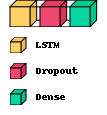

In [ ]:
lstm_model = keras.models.load_model('/content/drive/MyDrive/CMPSC 442 Final Project/Models/LSTM/lstm_model.h5')
print(f'{lstm_model.summary()}\n\n')
print(f'Diagram of LSTM MODEL')
visualkeras.layered_view(lstm_model, legend=True)


#Evaluation

In [ ]:
# make predictions
lstm_train_predict = lstm_model.predict(eval_X_train)
lstm_test_predict = lstm_model.predict(eval_X_test)

# invert predictions, due to transformations that occurred earlier
lstm_train_predict = scaler.inverse_transform(lstm_train_predict)
lstm_Y_train = scaler.inverse_transform(eval_Y_train)
lstm_test_predict = scaler.inverse_transform(lstm_test_predict)
lstm_Y_test = scaler.inverse_transform(eval_Y_test)



print('LSTM Train Mean Absolute Error:', mean_absolute_error(lstm_Y_train, lstm_train_predict))
print('LSTM Train Root Mean Squared Error:',np.sqrt(mean_squared_error(lstm_Y_train, lstm_train_predict)))
print('LSTM Test Mean Absolute Error:', mean_absolute_error(lstm_Y_test, lstm_test_predict))
print('LSTM Test Root Mean Squared Error:',np.sqrt(mean_squared_error(lstm_Y_test, lstm_test_predict)))
print('LSTM Test R squared:', r2_score(lstm_Y_test, lstm_test_predict))

12808/12808 [==============================] - 135s 11ms/step
LSTM Train Mean Absolute Error: 0.46145323
LSTM Train Root Mean Squared Error: 1.7455364
LSTM Test Mean Absolute Error: 0.4925863
LSTM Test Root Mean Squared Error: 1.5843077
LSTM Test R squared: 0.9135625126738718


In [ ]:
#Reset data
eval_X_train, eval_Y_train = X_train.copy(), Y_train.copy()
eval_X_test, eval_Y_test = X_test.copy(), Y_test.copy()

# make predictions
mlp_train_predict = mlp_model.predict(eval_X_train)
mlp_test_predict = mlp_model.predict(eval_X_test)

# invert predictions
mlp_train_predict = scaler.inverse_transform(mlp_train_predict)
mlp_Y_train = scaler.inverse_transform(eval_Y_train)
mlp_test_predict = scaler.inverse_transform(mlp_test_predict)
mlp_Y_test = scaler.inverse_transform(eval_Y_test)



print('MLP Train Mean Absolute Error:', mean_absolute_error(mlp_Y_train, mlp_train_predict))
print('MLP Train Root Mean Squared Error:',np.sqrt(mean_squared_error(mlp_Y_train, mlp_train_predict)))
print('MLP Test Mean Absolute Error:', mean_absolute_error(mlp_Y_test, mlp_test_predict))
print('MLP Test Root Mean Squared Error:',np.sqrt(mean_squared_error(mlp_Y_test, mlp_test_predict)))
print('MLP Test R squared:', r2_score(mlp_Y_test, mlp_test_predict))

12808/12808 [==============================] - 34s 3ms/step
MLP Train Mean Absolute Error: 0.6968746
MLP Train Root Mean Squared Error: 2.2806258
MLP Test Mean Absolute Error: 0.7533848
MLP Test Root Mean Squared Error: 2.1372461
MLP Test R squared: 0.8328584775870465


#MLP PLOTS

Plot 1: Global Active Power

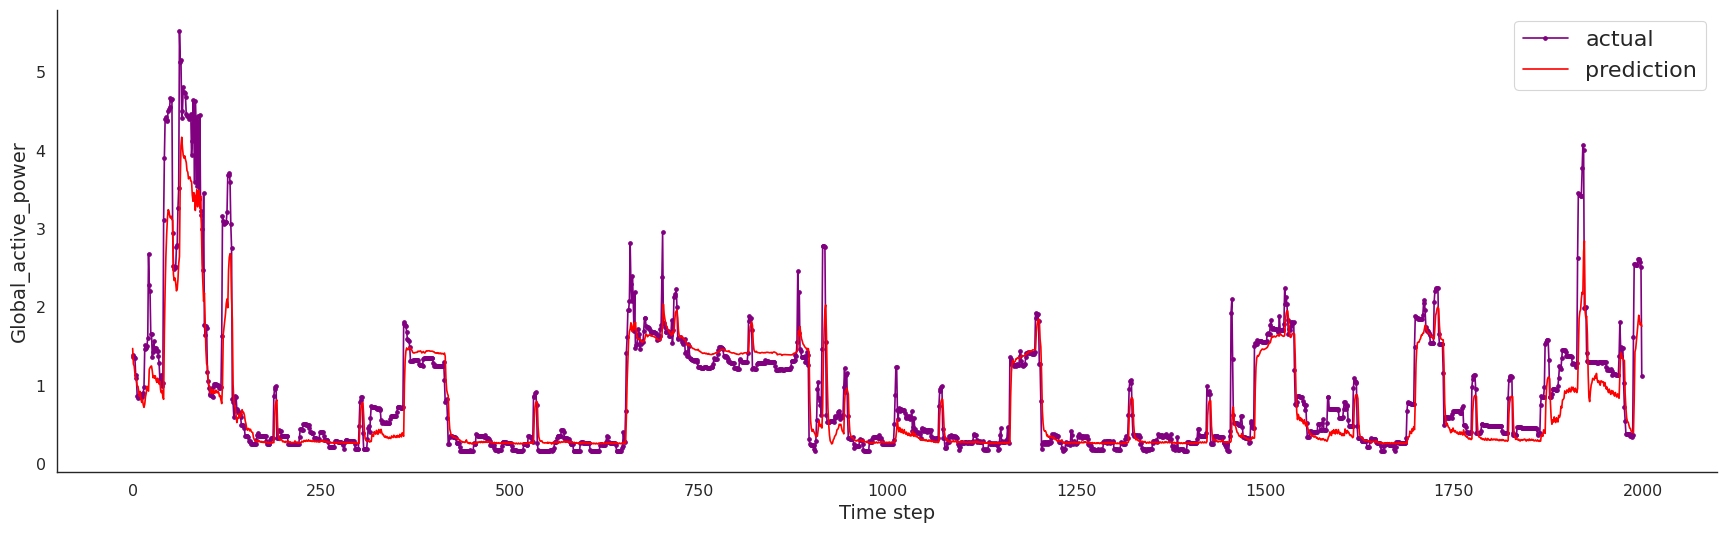

In [ ]:
rng = 2000

aa=[x for x in range(rng)]

#Create figure
plt.figure(figsize=(20,6))

#Plot actual
plt.plot(aa, mlp_Y_test[:,0][:rng], marker='.', label="actual", color='purple')

#Plot prediction
plt.plot(aa, mlp_test_predict[:,0][:rng], '-', label="prediction", color='red')


sns.despine(top=True)


plt.subplots_adjust(left=0.07)

#Labels
plt.ylabel('Global_active_power', size=14)
plt.xlabel('Time step', size=14)

plt.legend(fontsize=16)

#Show
plt.show()

Plot 2: Sub Metering 1

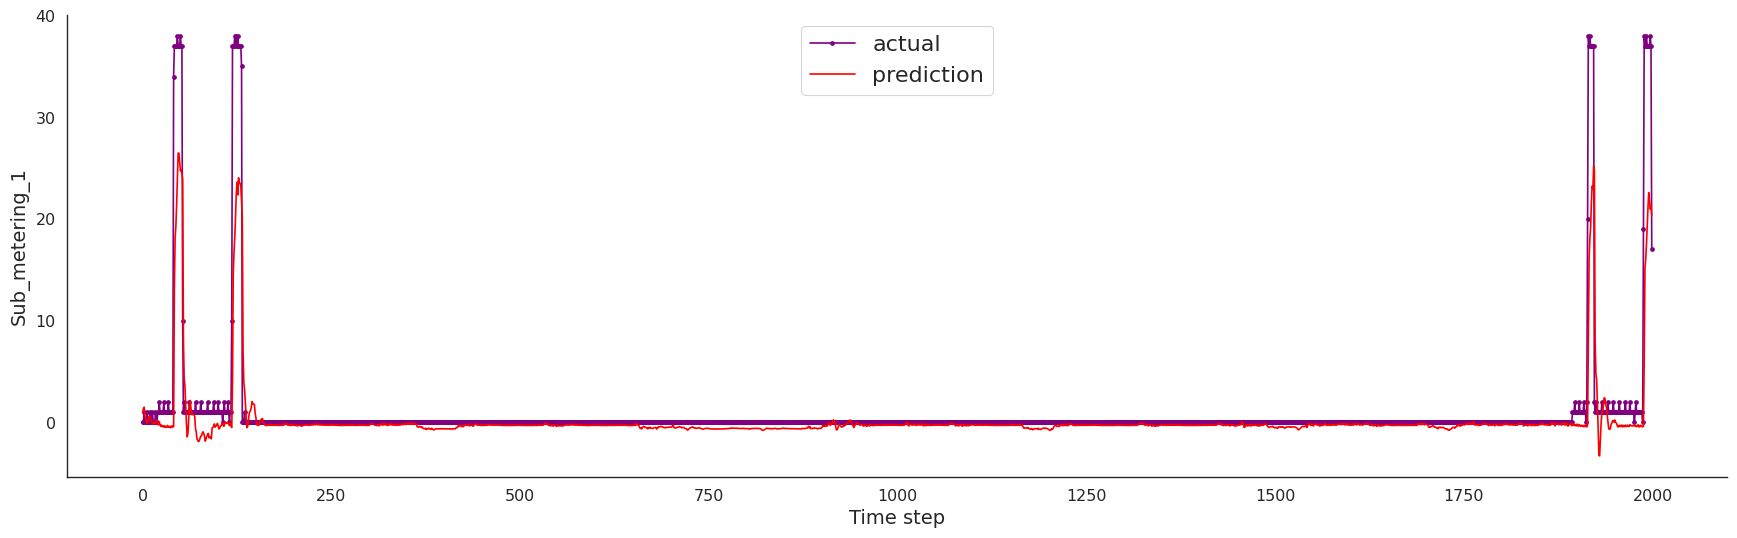

In [ ]:
rng = 2000

aa=[x for x in range(rng)]

#Create figure
plt.figure(figsize=(20,6))

#Plot actual
plt.plot(aa, mlp_Y_test[:,1][:rng], marker='.', label="actual", color='purple')

#Plot prediction
plt.plot(aa, mlp_test_predict[:,0][:rng], '-', label="prediction", color='red')


sns.despine(top=True)


plt.subplots_adjust(left=0.07)

#Labels
plt.ylabel('Global_active_power', size=14)
plt.xlabel('Time step', size=14)

plt.legend(fontsize=16)

#Show
plt.show()

Plot 3: Sub Metering 2

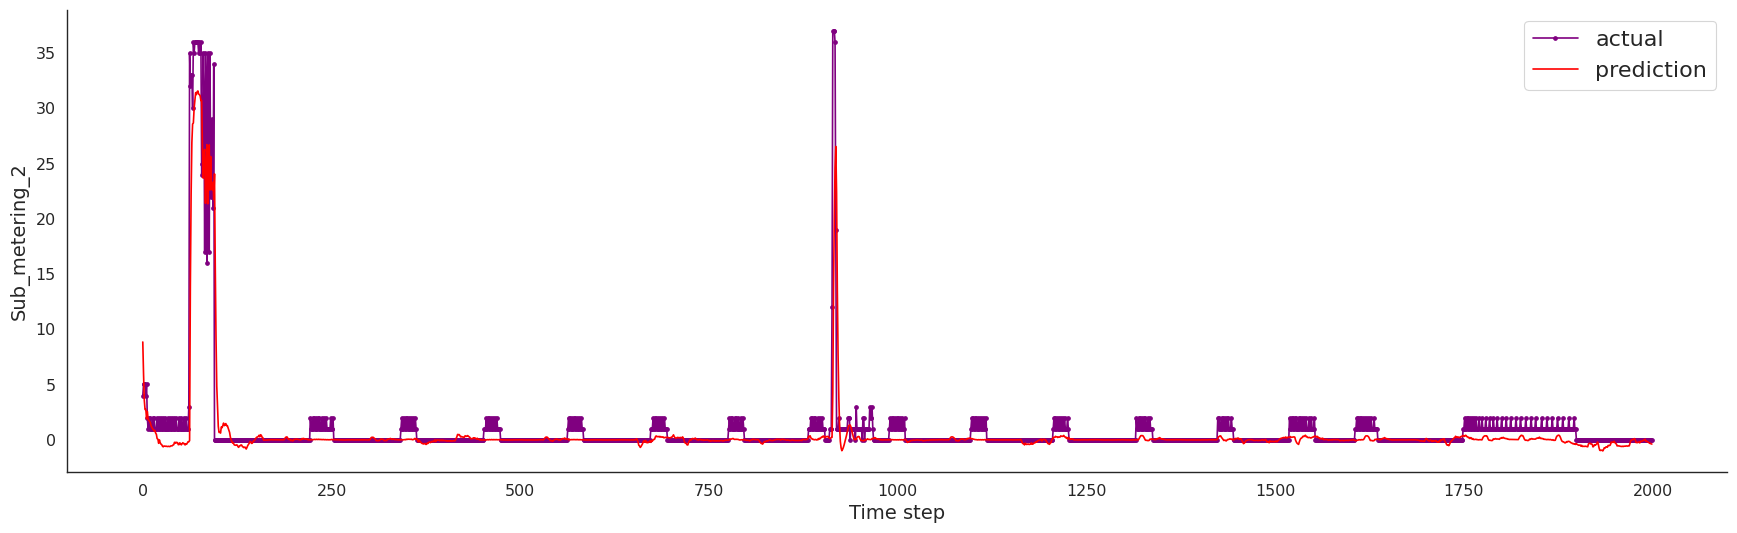

In [ ]:
rng = 2000

aa=[x for x in range(rng)]

#Create figure
plt.figure(figsize=(20,6))

#Plot actual
plt.plot(aa, mlp_Y_test[:,2][:rng], marker='.', label="actual", color='purple')

#Plot prediction
plt.plot(aa, mlp_test_predict[:,0][:rng], '-', label="prediction", color='red')


sns.despine(top=True)


plt.subplots_adjust(left=0.07)

#Labels
plt.ylabel('Global_active_power', size=14)
plt.xlabel('Time step', size=14)

plt.legend(fontsize=16)

#Show
plt.show()

Plot 4: Sub Metering 3

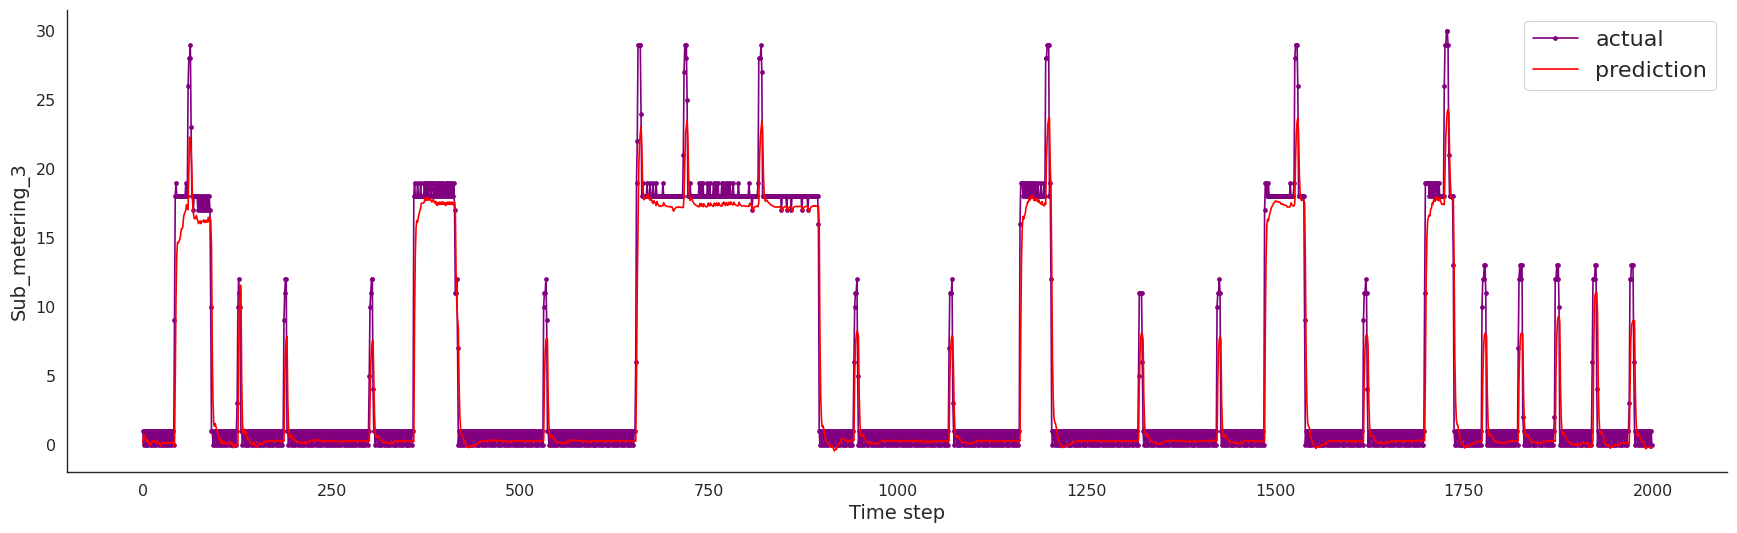

In [ ]:
rng = 2000

aa=[x for x in range(rng)]

#Create figure
plt.figure(figsize=(20,6))

#Plot actual
plt.plot(aa, mlp_Y_test[:,3][:rng], marker='.', label="actual", color='purple')

#Plot prediction
plt.plot(aa, mlp_test_predict[:,0][:rng], '-', label="prediction", color='red')


sns.despine(top=True)


plt.subplots_adjust(left=0.07)

#Labels
plt.ylabel('Global_active_power', size=14)
plt.xlabel('Time step', size=14)

plt.legend(fontsize=16)

#Show
plt.show()

#LSTM PLOTS

Plot 1: Global Active Power

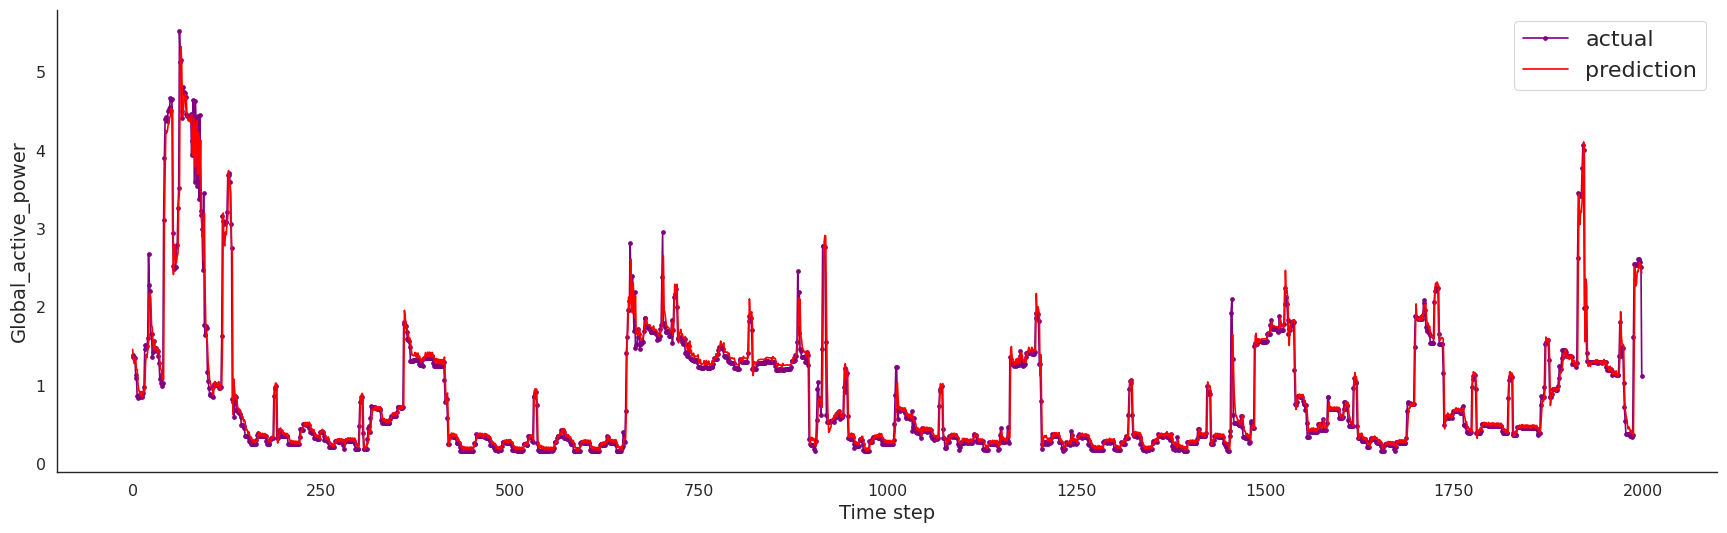

In [ ]:
rng = 2000

aa=[x for x in range(rng)]

# Creating figure
plt.figure(figsize=(20,6))

# Plotting the actual values in blue with a dot marker
plt.plot(aa, lstm_Y_test[:,0][:rng], marker='.', label="actual", color='blue')

# Plotting the predicted values in green with a solid line
plt.plot(aa, lstm_test_predict[:,0][:rng], '-', label="prediction", color='green')

# Remove top spines
sns.despine(top=True)

plt.subplots_adjust(left=0.07)

# Labeling
plt.ylabel('Global_active_power', size=14)
plt.xlabel('Time step', size=14)


plt.legend(fontsize=16)

plt.show()

Plot 2: Sub Metering 1

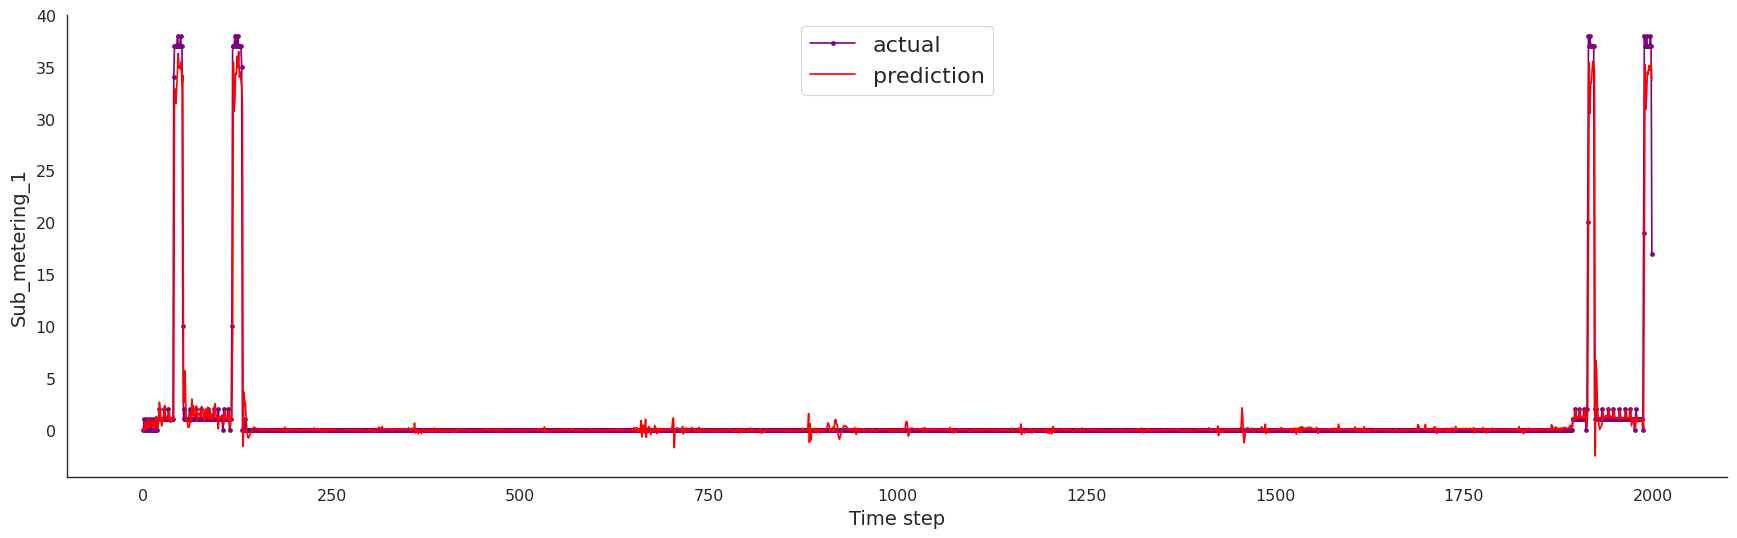

In [ ]:
rng = 2000

aa=[x for x in range(rng)]

plt.figure(figsize=(20,6))

plt.plot(aa, lstm_Y_test[:,1][:rng], marker='.', label="actual", color='blue')

plt.plot(aa, lstm_test_predict[:,1][:rng], '-', label="prediction", color='green')


sns.despine(top=True)


plt.subplots_adjust(left=0.07)

plt.ylabel('Sub_metering_1', size=14)
plt.xlabel('Time step', size=14)


plt.legend(fontsize=16)

plt.show()

Plot 3: Sub Metering 2

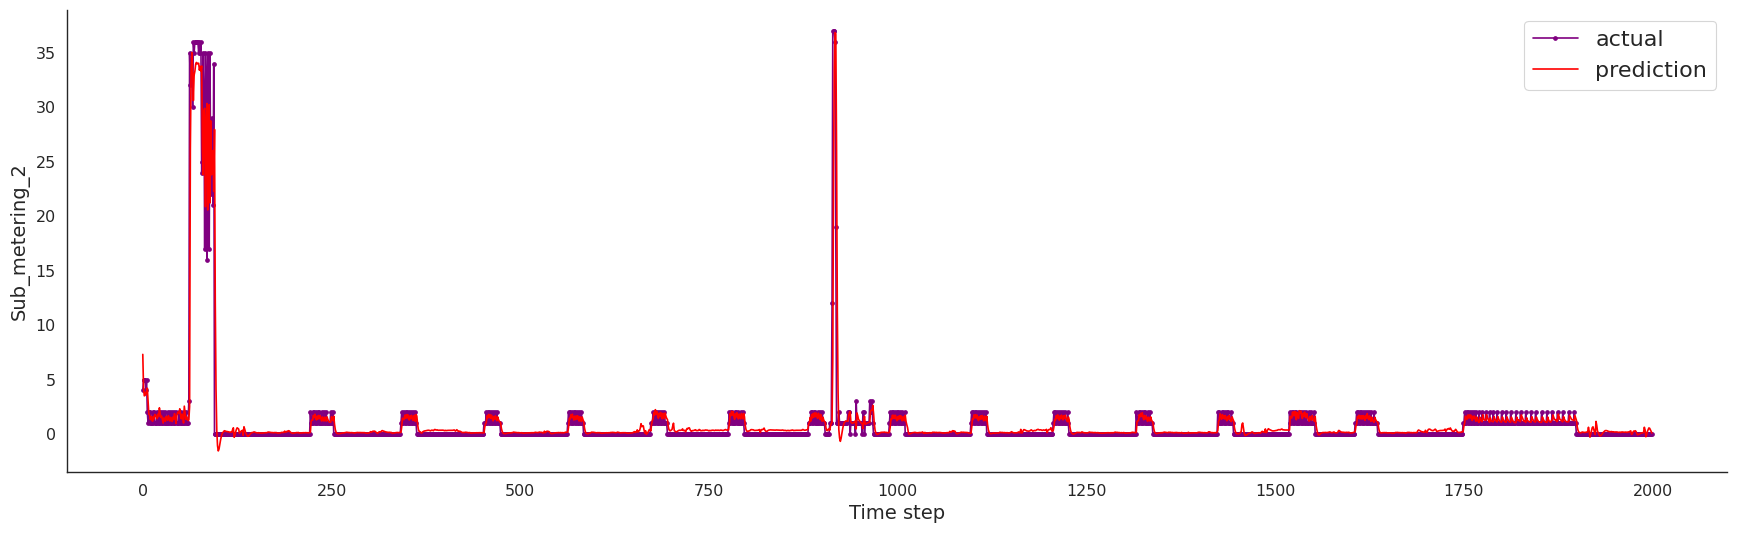

In [ ]:
rng = 2000

aa=[x for x in range(rng)]


plt.figure(figsize=(20,6))

plt.plot(aa, lstm_Y_test[:,2][:rng], marker='.', label="actual", color='blue')


plt.plot(aa, lstm_test_predict[:,2][:rng], '-', label="prediction", color='green')


sns.despine(top=True)

plt.subplots_adjust(left=0.07)


plt.ylabel('Sub_metering_2', size=14)
plt.xlabel('Time step', size=14)

plt.legend(fontsize=16)

plt.show()

Plot 4: Sub Metering 3

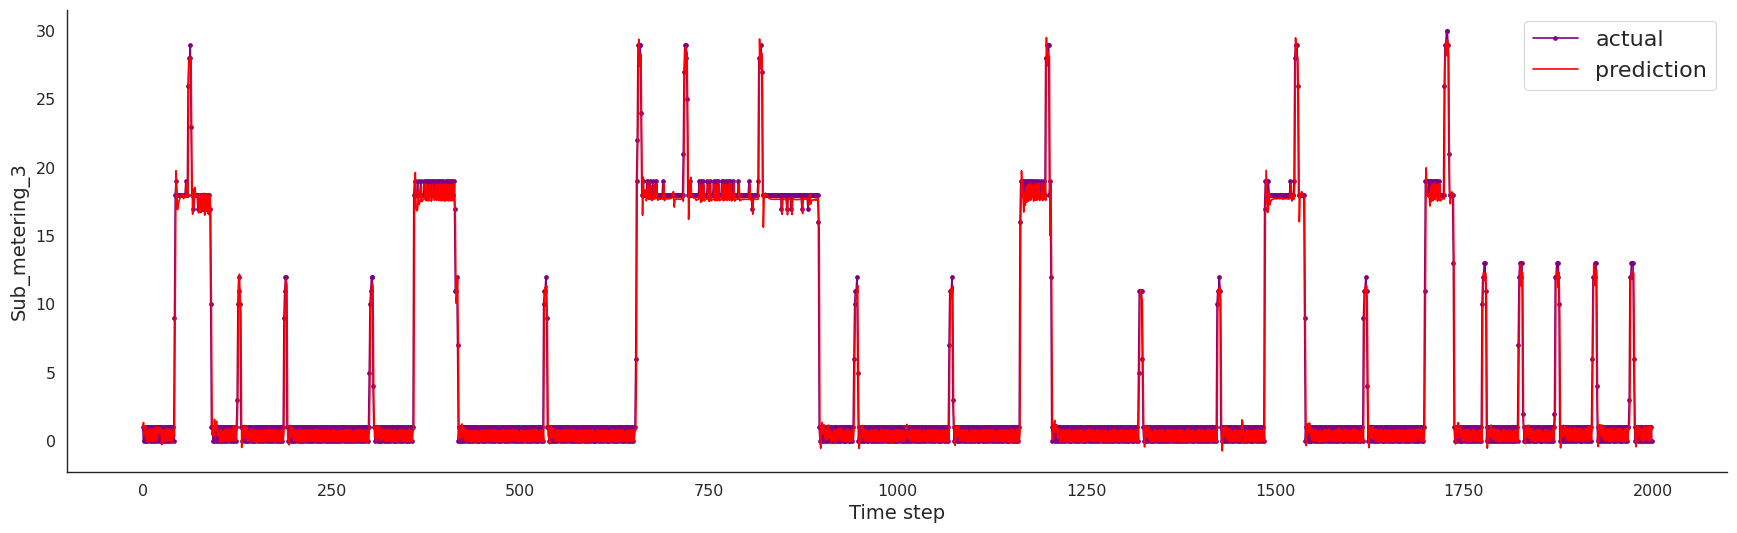

In [ ]:
rng = 2000

aa=[x for x in range(rng)]

plt.figure(figsize=(20,6))

plt.plot(aa, lstm_Y_test[:,3][:rng], marker='.', label="actual", color='blue')

plt.plot(aa, lstm_test_predict[:,3][:rng], '-', label="prediction", color='green')

sns.despine(top=True)

plt.subplots_adjust(left=0.07)

plt.ylabel('Sub_metering_3', size=14)
plt.xlabel('Time step', size=14)

plt.legend(fontsize=16)

plt.show()